This is a tutorial of exchange rate $-¥ prediction by machine learning (NN).
Interestingly, usually this type of time series data's prediction is good at RNN, but normal type of NN also good in this tutorial.

[Original Tutorial](http://www.algo-fx-blog.com/tensorflow-neural-network-fx/)

In [590]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

#Prepare Dataset

In [591]:
df = pd.read_csv("usd_jpy_api.csv")

In [592]:
df.head()

,time,close,open,high,low,volume
0,2016/08/19 06:00:00,100.256,99.919,100.471,99.887,30965
1,2016/08/22 06:00:00,100.335,100.832,100.944,100.221,32920
2,2016/08/23 06:00:00,100.253,100.339,100.405,99.950,26069
3,2016/08/24 06:00:00,100.460,100.270,100.619,100.104,22340
4,2016/08/25 06:00:00,100.546,100.464,100.627,100.314,17224


In [593]:
df.tail()

,time,close,open,high,low,volume
495,2018/07/17 06:00:00,112.908,112.320,112.933,112.231,19645
496,2018/07/18 06:00:00,112.866,112.914,113.144,112.723,17432
497,2018/07/19 06:00:00,112.501,112.887,113.187,112.072,26697
498,2018/07/20 06:00:00,111.474,112.504,112.631,111.401,33445
499,2018/07/23 06:00:00,111.164,111.420,111.523,110.760,16040


The goal of this tutorial is predict latest close value (499 row).
So little bit shift data.

In [594]:
df_shift =df.copy()
df_shift.close = df_shift.close.shift(-1)

#Check
df_shift.tail()

,time,close,open,high,low,volume
495,2018/07/17 06:00:00,112.866,112.320,112.933,112.231,19645
496,2018/07/18 06:00:00,112.501,112.914,113.144,112.723,17432
497,2018/07/19 06:00:00,111.474,112.887,113.187,112.072,26697
498,2018/07/20 06:00:00,111.164,112.504,112.631,111.401,33445
499,2018/07/23 06:00:00,NaN,111.420,111.523,110.760,16040


In [595]:
#remove 499 row
df_2 = df_shift[:-1]
#delete time column
del df_2["time"]

print(df_2.shape)

(499, 5)


In [596]:
#Store the shape of dataset
n = df_2.shape[0]
p = df_2.shape[1]

#devide dataset  7:3
train_start = 0
train_end=int(np.floor(0.8*n))
test_start=train_end +1
test_end =n

#do not shaffle because this is a time series data
df_train=df_2.loc[np.arange(train_start, train_end), :]
df_test=df_2.loc[np.arange(test_start, test_end), :]

#check
df_test[96:99]
df_train.shape
df_test.shape

(99, 5)

In [597]:
#scaling data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_test_scaled =scaler.transform(df_test)

In [598]:
#devide x and y
x_train=df_train_scaled[:,1:]
y_train=df_train_scaled[:, 0]
x_test=df_test_scaled[:,1:]
y_test=df_test_scaled[:, 0]

#Build Neural Network

In [619]:
n_train = x_train.shape[1]

#set 3 hidden layer NN stracture
n_nn_1 = 258
n_nn_2 =64
n_nn_3=32
n_nn_4=4

net=tf.InteractiveSession()

x = tf.placeholder(dtype=tf.float32, shape=[None, n_train])
y = tf.placeholder(dtype=tf.float32, shape=[None])

#initialize
sigma=1
w_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma, seed=0)
b_initializer = tf.zeros_initializer()

/Users/hasegawatooru/anaconda3/envs/kaggle/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [600]:
w_hidden_1 =tf.Variable(w_initializer([n_train, n_nn_1]))
b_hidden_1=tf.Variable(b_initializer([n_nn_1]))
w_hidden_2 =tf.Variable(w_initializer([n_nn_1, n_nn_2]))
b_hidden_2=tf.Variable(b_initializer([n_nn_2]))
w_hidden_3 =tf.Variable(w_initializer([n_nn_2, n_nn_3]))
b_hidden_3=tf.Variable(b_initializer([n_nn_3]))
w_hidden_4 =tf.Variable(w_initializer([n_nn_3, n_nn_4]))
b_hidden_4=tf.Variable(b_initializer([n_nn_4]))

In [601]:
#set activation function
hidden_1 =tf.nn.relu(tf.add(tf.matmul(x, w_hidden_1), b_hidden_1))
hidden_2=tf.nn.relu(tf.add(tf.matmul(hidden_1, w_hidden_2), b_hidden_2))
hidden_3=tf.nn.relu(tf.add(tf.matmul(hidden_2, w_hidden_3), b_hidden_3))
hidden_4=tf.nn.relu(tf.add(tf.matmul(hidden_3, w_hidden_4), b_hidden_4))

In [602]:
#build output layer
w_out = tf.Variable(w_initializer([n_nn_4, 1]))
b_out = tf.Variable(b_initializer([1]))

#set output. scaling data transform original value.
out=tf.transpose(tf.add(tf.matmul(hidden_4, w_out), b_out))

In [603]:
#define cost function
cost=tf.reduce_mean(tf.squared_difference(out, y))

#set optimizor
opt = tf.train.AdamOptimizer(0.002).minimize(cost)

#initialize
net.run(tf.global_variables_initializer())

Training NN

In [618]:
batch_size = 32
cost_train=[]
cost_test=[]

epochs =500
for i in range(epochs):
    sff_idx =np.random.permutation(n_train)
    for idx in range(0, n_train, batch_size):
        batch_x = x_train[sff_idx[idx:idx+batch_size
                                 if idx + batch_size < n_train else n_train]]
        batch_y = y_train[sff_idx[idx:idx+batch_size
                                 if idx + batch_size < n_train else n_train]]
    net.run(opt, feed_dict={x:x_train, y:y_train})
    
    if i % 25 == 0:
      train_loss = net.run(cost, feed_dict = {x: x_train, y: y_train})
     # train_acc = net.run(acc, feed_dict = {X: train_x, t: train_t})
      test_loss = net.run(cost, feed_dict = {x: x_test, y: y_test})
      #test_acc = net.run(acc, feed_dict = {X: test_x, t: test_t}) 
      print('i:{} \n \
             tr_loss:{}\n \
             tes_loss:{} '.format(i,
                                train_loss,
                                test_loss))

i:0 
              tr_loss:0.004467617720365524
              tes_loss:0.0031404001638293266 
i:25 
              tr_loss:0.004425217397511005
              tes_loss:0.0031573940068483353 
i:50 
              tr_loss:0.0043830256909132
              tes_loss:0.0030648389365524054 
i:75 
              tr_loss:0.004346985835582018
              tes_loss:0.0030649767722934484 
i:100 
              tr_loss:0.0043489704839885235
              tes_loss:0.0029978209640830755 
i:125 
              tr_loss:0.004275677725672722
              tes_loss:0.0031114909797906876 
i:150 
              tr_loss:0.004243556410074234
              tes_loss:0.0030535049736499786 
i:175 
              tr_loss:0.0042144604958593845
              tes_loss:0.0030379637610167265 
i:200 
              tr_loss:0.00418242858722806
              tes_loss:0.003158931154757738 
i:225 
              tr_loss:0.0041699944995343685
              tes_loss:0.003047271864488721 
i:250 
              tr_loss:0.0042148223146796

#Predict tomorrow exchange rate

In [605]:
pred_test=net.run(out, feed_dict={x:x_test})

print(pred_test[0][0:5])

[-0.32974985 -0.36893794 -0.33551902 -0.25524724 -0.2874201 ]


In [606]:
#back to the actual number
pred_test=np.concatenate((pred_test.T, x_test), axis=1)
pred_test_inv = scaler.inverse_transform(pred_test)

In [607]:
df_shift.tail(1)

,time,close,open,high,low,volume
499,2018/07/23 06:00:00,NaN,111.42,111.523,110.76,16040


In [608]:
print(df_test.values[98])
print(pred_test_inv[98])

[  111.164   112.504   112.631   111.401 33445.   ]
[  111.97115152   112.504        112.631        111.401
 33445.        ]


It looks no good.
But this NN can predict future value!

Lastly, let's check the accuracy of prediction.

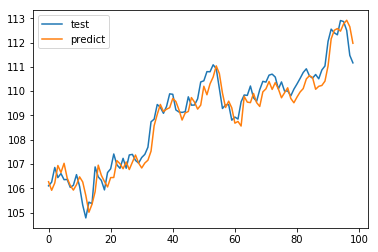

In [609]:
plt.ion()
fig=plt.figure()
ax1=fig.add_subplot(111)
line1, =ax1.plot(df_test.values[:,0])
line2, =ax1.plot(pred_test_inv[:,0])
plt.legend(["test", "predict"])
plt.show()

In [610]:
#Check error level
MAE_test = mean_absolute_error(df_test, pred_test_inv)
print(MAE_test)

0.07978474223882862


AttributeError: 'Tensor' object has no attribute 'head'